In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install timm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from timm.models.layers.adaptive_avgmax_pool import SelectAdaptivePool2d
from torch.nn import Flatten

from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai.callback.fp16 import *

#import pydicom
#!pip install -qU python-gdcm pydicom pylibjpeg

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 6.1 MB/s eta 0:00:00a 0:00:01


In [2]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
df['filepath'] = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/' + df['patient_id'].astype(str) + '/' + df['image_id'].astype(str) + '.png'
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,filepath
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10011/220375232.png


In [4]:
df.iloc[0,-1]

'/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png'

In [5]:
df.density.value_counts()

B    12651
C    12175
A     3105
D     1539
Name: density, dtype: int64

In [6]:
df = df[['filepath', 'cancer']]
df.head()

,filepath,cancer
0,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png,0
1,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1459541791.png,0
2,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1864590858.png,0
3,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1874946579.png,0
4,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10011/220375232.png,0


In [7]:
df.cancer.value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

# Train Test Split

In [8]:
# from sklearn.model_selection import train_test_split

# # Split the data into training and testing sets, stratified by the "target" column
# train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cancer'], random_state=1)
# print('shape of train_df', train_df.shape)
# print('shape of test_df', test_df.shape)

# Sampling

In [9]:
def sampler(df, majority_class_ratio, minority_class_ratio):
    # Class count
    count_class_0, count_class_1 = df.cancer.value_counts()
    
    # Divide by class
    df_class_0 = df[df['cancer'] == 0]
    df_class_1 = df[df['cancer'] == 1]
    
    df_class_0_sampled = df_class_0.sample(count_class_1*majority_class_ratio, random_state=1)
    df_class_1_sampled = df_class_1.sample(count_class_1*minority_class_ratio, replace=True)
    df_sampled = pd.concat([df_class_0_sampled, df_class_1_sampled], axis=0)
    df_sampled = df_sampled.sample(frac = 1)
    
    print('Data in sampled dataframe:')
    print(df_sampled.cancer.value_counts())
    print('-----------')
    print('Dataframe shape:')
    print(df_sampled.shape)
    
    return df_sampled

In [10]:
df_sampled = sampler(df, 20, 1)

Data in sampled dataframe:
0    23160
1     1158
Name: cancer, dtype: int64
-----------
Dataframe shape:
(24318, 2)


In [11]:
df_sampled.head()

,filepath,cancer
31797,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/44070/1272266200.png,0
4873,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/1524/1559332263.png,1
10816,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/21660/1174434605.png,0
50082,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/64033/1965748696.png,0
25324,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/37076/1566548904.png,0


# Training

In [12]:
db = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                   get_x=lambda x:x[0],
                   get_y=lambda x:x[1],
                   splitter  = RandomSplitter(seed=1))

dls = db.dataloaders(df_sampled.values, num_workers=0, bs=32)

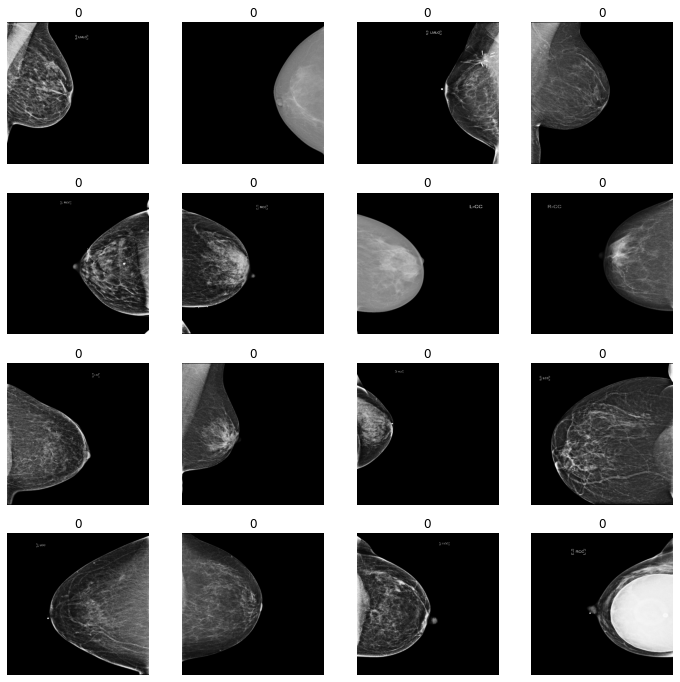

In [13]:
dls.show_batch(max_n=16)

In [14]:
def get_learner(arch=resnet18):
    learner = vision_learner(
        dls,
        arch,
        custom_head=nn.Sequential(SelectAdaptivePool2d(pool_type='avg', flatten=Flatten()), nn.Linear(1280, 2)),
        metrics=[
            error_rate,
            accuracy,
            F1Score()
        ],
        loss_func=CrossEntropyLossFlat(weight=torch.tensor([1,20]).float()),
        pretrained=True,
        #normalize=False
    ).to_fp16()
    return learner

In [15]:
learn = get_learner('tf_efficientnetv2_s')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_s-eb54923e.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_s-eb54923e.pth


In [16]:
#learn.summary()

In [17]:
#learn = vision_learner(dls, resnet18, metrics=error_rate).to_fp16()

SuggestedLRs(valley=0.001737800776027143)

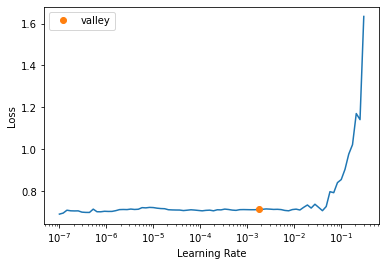

In [18]:
learn.lr_find()

In [19]:
# learn.unfreeze()
learn.fit_one_cycle(6, 0.001)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,0.632666,0.637627,0.178696,0.821304,0.162006,12:22
1,0.602770,0.578976,0.154431,0.845569,0.226571,09:35
2,0.441165,0.541477,0.171910,0.828090,0.276817,09:32
3,0.329710,0.534195,0.177051,0.822949,0.280702,09:35
4,0.234623,0.605074,0.123792,0.876208,0.335541,09:31
5,0.228373,0.601382,0.123998,0.876002,0.335171,09:33


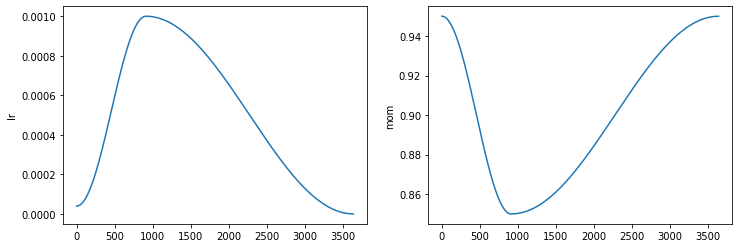

In [20]:
learn.recorder.plot_sched()

In [ ]:
#learn.lr_find()

In [ ]:
#learn.fit_one_cycle(6, 0.0006)

In [ ]:
#learn.unfreeze()

In [ ]:
#learn.lr_find()

In [ ]:
#learn.fit_one_cycle(6, 1e-5)

In [ ]:
#learn.recorder.plot_sched()

In [ ]:
#learn.activation_stats.plot_layer_stats(0)

In [ ]:
learn.recorder.plot_loss()

In [21]:
learn.save('flw10_512_ch_enetv2_s_ft', with_opt=False)

Path('models/flw10_512_ch_enetv2_s_ft.pth')

# Validation Data Metric

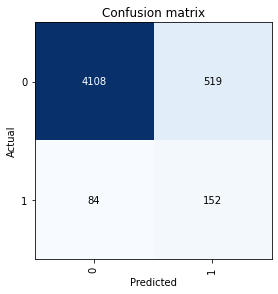

In [22]:
# # # interp = ClassificationInterpretation.from_learner(learn)
# # # losses,idxs = interp.top_losses()
# # # len(dls.valid_ds)==len(losses)==len(idxs)
# # # interp.plot_confusion_matrix(figsize=(7,7))

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
#interp.plot_top_losses(5, nrows=1)